In [1]:
from psruq.source.postprocessing_utils import (
    get_sampled_combinations_uncertainty_scores,
    ENSEMBLE_COMBINATIONS,
)
from source.notebook.reliability_diagrams import (
    reliability_diagram,
    compute_calibration,
)
from source.datasets.constants import DatasetName
from source.losses.constants import LossName
from source.models.constants import ModelName
from source.metrics import (
    ApproximationType,
    GName,
    RiskType,
    get_central_prediction,
    posterior_predictive,
)
from source.metrics.utils import safe_softmax

import pandas as pd
import numpy as np

pd.set_option("display.max_rows", None)

stty: 'standard input': Inappropriate ioctl for device
/home/nkotelevskii/github/uncertainty_from_proper_scoring_rules/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_accuracy(true_labels, pred_labels):
    return np.mean(pred_labels == true_labels)

In [3]:
architecture = ModelName.RESNET18
model_ids = np.arange(20)
list_extraction_datasets = [
    "cifar10",
    "cifar100",
    "svhn",
    "blurred_cifar100",
    "blurred_cifar10",
]
temperature = 1.0

In [4]:
def get_ece_and_accuracy(
    logits_,
    temperature_,
    true_labels_,
):
    accuracies_bma = []
    ece_bma = []

    accuracies_central = []
    ece_central = []

    accuracies_raw = []
    ece_raw = []

    for comb in ENSEMBLE_COMBINATIONS:
        comb = list(comb)
        selected_logits = logits_[comb]

        prob_bma = np.squeeze(
            posterior_predictive(logits_=selected_logits, T=temperature_)
        )
        pred_bma = np.argmax(prob_bma, axis=-1)

        for central_name in [el for el in GName]:
            prob_central = np.squeeze(
                get_central_prediction(g_name=central_name)(
                    logits=selected_logits, T=temperature_
                )
            )
            pred_central = np.argmax(prob_central, axis=-1)

            accuracy_central = get_accuracy(
                true_labels=true_labels_, pred_labels=pred_central
            )
            accuracies_central.append({central_name.value: float(accuracy_central)})

            ece_central.append(
                {
                    central_name.value: float(
                        compute_calibration(
                            true_labels=true_labels_,
                            pred_labels=np.argmax(prob_central, axis=-1),
                            confidences=np.max(prob_central, axis=-1),
                        )["expected_calibration_error"]
                    )
                }
            )

        accuracy_bma = get_accuracy(true_labels=true_labels_, pred_labels=pred_bma)
        accuracy_raw = get_accuracy(
            true_labels=true_labels_, pred_labels=np.argmax(selected_logits, axis=-1)
        )

        accuracies_bma.append(float(accuracy_bma))

        accuracies_raw.append(float(accuracy_raw))

        ece_bma.append(
            float(
                compute_calibration(
                    true_labels=true_labels_,
                    pred_labels=np.argmax(prob_bma, axis=-1),
                    confidences=np.max(prob_bma, axis=-1),
                )["expected_calibration_error"]
            )
        )

        ece_raw.append(
            float(
                np.mean(
                    [
                        compute_calibration(
                            true_labels=true_labels_,
                            pred_labels=np.argmax(safe_softmax(el), axis=-1),
                            confidences=np.max(safe_softmax(el), axis=-1),
                        )["expected_calibration_error"]
                        for el in selected_logits
                    ]
                )
            )
        )

    return (
        accuracies_bma,
        ece_bma,
        accuracies_central,
        ece_central,
        accuracies_raw,
        ece_raw,
    )

In [5]:
accuracy_dict = {}
ece_dict = {}

for (training_dataset_name,) in [
    ("cifar10",),
    ("cifar100",),
]:
    accuracy_dict[training_dataset_name] = {}
    ece_dict[training_dataset_name] = {}

    for loss_function_names in [
        LossName.CROSS_ENTROPY,
        LossName.BRIER_SCORE,
        LossName.SPHERICAL_SCORE,
    ]:
        accuracy_dict[training_dataset_name][loss_function_names.value] = {}
        ece_dict[training_dataset_name][loss_function_names.value] = {}

        uq_results, embeddings_per_dataset, targets_per_dataset = (
            get_sampled_combinations_uncertainty_scores(
                loss_function_names=[loss_function_names],
                training_dataset_name=training_dataset_name,
                architecture=architecture,
                model_ids=model_ids,
                list_extraction_datasets=list_extraction_datasets,
                temperature=temperature,
                use_cached=True,
            )
        )

        logits = embeddings_per_dataset[loss_function_names.value][
            training_dataset_name
        ]
        max_ind = int(
            targets_per_dataset[training_dataset_name].shape[0] / len(model_ids)
        )
        true_labels = targets_per_dataset[training_dataset_name][:max_ind]

        #######

        (
            accuracies_bma,
            ece_bma,
            accuracies_central,
            ece_central,
            accuracies_raw,
            ece_raw,
        ) = get_ece_and_accuracy(
            logits_=logits,
            temperature_=temperature,
            true_labels_=true_labels,
        )

        accuracy_dict[training_dataset_name][loss_function_names.value]["bma"] = (
            accuracies_bma
        )
        accuracy_dict[training_dataset_name][loss_function_names.value]["central"] = (
            accuracies_central
        )
        accuracy_dict[training_dataset_name][loss_function_names.value]["raw"] = (
            accuracies_raw
        )

        ece_dict[training_dataset_name][loss_function_names.value]["bma"] = ece_bma
        ece_dict[training_dataset_name][loss_function_names.value]["central"] = (
            ece_central
        )
        ece_dict[training_dataset_name][loss_function_names.value]["raw"] = ece_raw


def ravel_dict(dict_):
    for dataset_name, dataset in dict_.items():
        for loss_name, loss in dataset.items():
            central = loss["central"]

            logscore_list = [el["LogScore"] for el in central if "LogScore" in el]
            # brier_list = [el['BrierScore'] for el in central if "BrierScore" in el]
            # zeroone_list = [el['ZeroOneScore'] for el in central if "ZeroOneScore" in el]
            spherical_list = [
                el["SphericalScore"] for el in central if "SphericalScore" in el
            ]

            central = {
                "LogScore": logscore_list,
                # "BrierScore": brier_list,
                # "ZeroOneScore": zeroone_list,
                "SphericalScore": spherical_list,
            }

            dict_[dataset_name][loss_name]["central"] = central
    return dict_


accuracy_dict = ravel_dict(accuracy_dict)
ece_dict = ravel_dict(ece_dict)

In [15]:
ece_dict["cifar10"]["CrossEntropy"]["central"]

{'LogScore': [0.01827602108120918,
  0.01711895966231823,
  0.019362305691838264,
  0.018171447694301606,
  0.019430832040309907],
 'SphericalScore': [0.023966585083305837,
  0.022483455276489258,
  0.02184618239402771,
  0.023699307112395762,
  0.022297505536675453]}

In [7]:
def mean_std_df(dict_):
    # Initialize a dictionary to store results
    rows = []
    rows_std = []

    # Loop through the datasets, loss functions, and estimation methods
    for dataset_name, loss_functions in dict_.items():
        row = {"Dataset": dataset_name}
        row_std = {"Dataset": dataset_name}
        for loss_func_name, estimations in loss_functions.items():
            # Calculate the mean for 'bma' and 'raw' lists
            bma_mean = np.mean(estimations.get("bma", []))
            raw_mean = np.mean(estimations.get("raw", []))

            bma_std = np.std(estimations.get("bma", []))
            raw_std = np.std(estimations.get("raw", []))

            # Add 'BMA' and 'Raw' means to the row
            row[(loss_func_name, "BMA")] = bma_mean
            row[(loss_func_name, "Raw")] = raw_mean

            row_std[(loss_func_name, "BMA")] = bma_std
            row_std[(loss_func_name, "Raw")] = raw_std

            # Handle 'central' dict by calculating the mean for each function
            if "central" in estimations:
                for func_name, values in estimations["central"].items():
                    row[(loss_func_name, f"central_{func_name}")] = np.mean(values)
                    row_std[(loss_func_name, f"central_{func_name}")] = np.std(values)

        rows.append(row)
        rows_std.append(row_std)

    # Create a DataFrame with multi-index columns
    df = pd.DataFrame(rows)
    df_std = pd.DataFrame(rows_std)

    # Set 'Dataset' as the index
    df.set_index("Dataset", inplace=True)
    df_std.set_index("Dataset", inplace=True)

    return df, df_std

In [8]:
df_acc, df_acc_std = mean_std_df(accuracy_dict)

In [9]:
# # Display the resulting DataFrame
# import ace_tools as tools

# tools.display_dataframe_to_user(name="Multi-Level Loss Estimation Table", dataframe=df)

In [10]:
df_acc

,"(CrossEntropy, BMA)","(CrossEntropy, Raw)","(CrossEntropy, central_LogScore)","(CrossEntropy, central_SphericalScore)","(BrierScore, BMA)","(BrierScore, Raw)","(BrierScore, central_LogScore)","(BrierScore, central_SphericalScore)","(SphericalScore, BMA)","(SphericalScore, Raw)","(SphericalScore, central_LogScore)","(SphericalScore, central_SphericalScore)"
Dataset,,,,,,,,,,,,
cifar10,0.96184,0.95460,0.96232,0.96166,0.96090,0.952390,0.96078,0.96072,0.96094,0.951345,0.96074,0.96080
cifar100,0.78998,0.75943,0.79154,0.78940,0.78968,0.754185,0.79066,0.78998,0.79134,0.757240,0.79272,0.79234


In [11]:
df_acc_std

,"(CrossEntropy, BMA)","(CrossEntropy, Raw)","(CrossEntropy, central_LogScore)","(CrossEntropy, central_SphericalScore)","(BrierScore, BMA)","(BrierScore, Raw)","(BrierScore, central_LogScore)","(BrierScore, central_SphericalScore)","(SphericalScore, BMA)","(SphericalScore, Raw)","(SphericalScore, central_LogScore)","(SphericalScore, central_SphericalScore)"
Dataset,,,,,,,,,,,,
cifar10,0.000840,0.000512,0.000605,0.000605,0.000812,0.000473,0.000898,0.000730,0.000476,0.000472,0.000463,0.000610
cifar100,0.000806,0.000714,0.000731,0.000932,0.001491,0.001447,0.001003,0.001342,0.000706,0.001630,0.001462,0.001347


In [12]:
df_ece, df_ece_std = mean_std_df(ece_dict)

In [13]:
df_ece

,"(CrossEntropy, BMA)","(CrossEntropy, Raw)","(CrossEntropy, central_LogScore)","(CrossEntropy, central_SphericalScore)","(BrierScore, BMA)","(BrierScore, Raw)","(BrierScore, central_LogScore)","(BrierScore, central_SphericalScore)","(SphericalScore, BMA)","(SphericalScore, Raw)","(SphericalScore, central_LogScore)","(SphericalScore, central_SphericalScore)"
Dataset,,,,,,,,,,,,
cifar10,0.007725,0.024922,0.018472,0.022859,0.015652,0.008664,0.011266,0.034835,0.068188,0.049359,0.060973,0.085518
cifar100,0.030184,0.051327,0.037578,0.170132,0.084922,0.040935,0.058025,0.216458,0.301348,0.257491,0.297075,0.374534


In [14]:
df_ece_std

,"(CrossEntropy, BMA)","(CrossEntropy, Raw)","(CrossEntropy, central_LogScore)","(CrossEntropy, central_SphericalScore)","(BrierScore, BMA)","(BrierScore, Raw)","(BrierScore, central_LogScore)","(BrierScore, central_SphericalScore)","(SphericalScore, BMA)","(SphericalScore, Raw)","(SphericalScore, central_LogScore)","(SphericalScore, central_SphericalScore)"
Dataset,,,,,,,,,,,,
cifar10,0.000696,0.000620,0.000857,0.000826,0.001047,0.000484,0.000838,0.001252,0.000977,0.000669,0.000589,0.000997
cifar100,0.000852,0.001122,0.001740,0.001466,0.001789,0.001363,0.001939,0.001425,0.001021,0.000924,0.001128,0.001639


In [10]:
logits.shape

(20, 10000, 100)

In [11]:
ENSEMBLE_COMBINATIONS[0]

(0, 1, 2, 3)

In [12]:
logits[list(ENSEMBLE_COMBINATIONS[0])].shape

(4, 10000, 100)

In [13]:
np.vstack(uq_results["LogScore TotalRisk outer outer"]["CrossEntropy"]["cifar10"]).shape

(5, 10000)

{'accuracies': array([0.39141288, 0.6983471 , 0.84641254, 0.92396694, 0.95108694,
        0.9713805 , 0.96390975, 0.98763907, 0.9882468 , 0.992416  ],
       dtype=float32),
 'confidences': array([0.06680089, 0.14222819, 0.24538441, 0.34697264, 0.45137143,
        0.54799205, 0.6505524 , 0.7519996 , 0.8516781 , 0.9429651 ],
       dtype=float32),
 'counts': array([2003, 1936,  892,  605,  552,  594,  665,  809, 1021,  923],
       dtype=int32),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': np.float64(0.7916999912530184),
 'avg_confidence': np.float64(0.4193526729285717),
 'expected_calibration_error': np.float64(0.37234731965363027),
 'max_calibration_error': np.float32(0.60102814)}

{'accuracies': array([0.3119349 , 0.55172414, 0.7120773 , 0.78281623, 0.8736559 ,
        0.9353169 , 0.9643678 , 0.97727275, 0.98528206, 0.9920556 ],
       dtype=float32),
 'confidences': array([0.06590089, 0.146985  , 0.24813367, 0.34859797, 0.4483385 ,
        0.5500568 , 0.652477  , 0.7512756 , 0.85148907, 0.9426436 ],
       dtype=float32),
 'counts': array([1106, 1392, 1035,  838,  744,  773,  870, 1012, 1223, 1007],
       dtype=int32),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': np.float64(0.7910999953269958),
 'avg_confidence': np.float64(0.49037498577684163),
 'expected_calibration_error': np.float64(0.3007250110924244),
 'max_calibration_error': np.float32(0.46394366)}

/home/nkotelevskii/github/uncertainty_from_proper_scoring_rules/psruq/source/notebook/reliability_diagrams.py:225: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


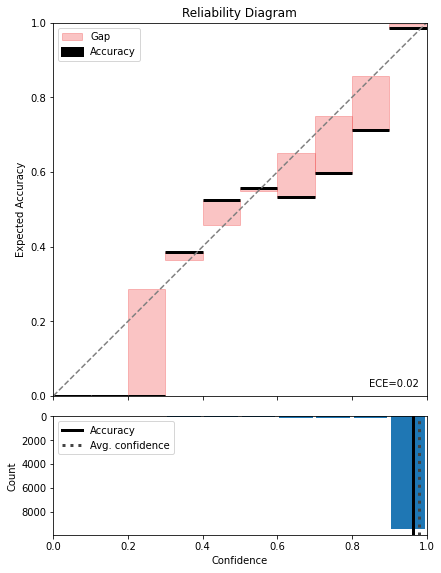

In [12]:
reliability_diagram(
    true_labels=true_labels,
    pred_labels=np.argmax(prob_central, axis=-1),
    confidences=np.max(prob_central, axis=-1),
    num_bins=10,
)

/home/nkotelevskii/github/uncertainty_from_proper_scoring_rules/psruq/source/notebook/reliability_diagrams.py:225: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


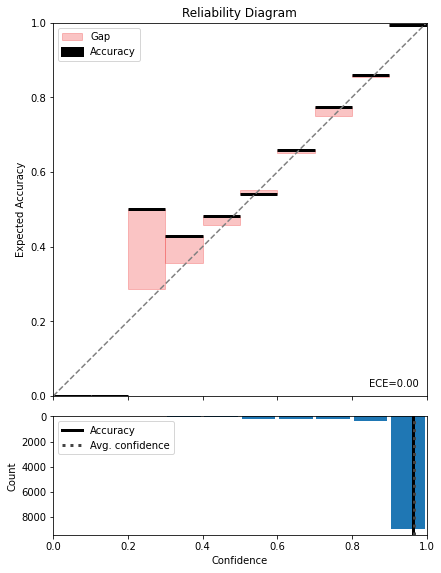

In [13]:
reliability_diagram(
    true_labels=true_labels,
    pred_labels=np.argmax(prob_bma, axis=-1),
    confidences=np.max(prob_bma, axis=-1),
    num_bins=10,
)